In [1]:
%matplotlib inline
import autograd.numpy.random as npr
import autograd.numpy as np
from autograd import grad
from autograd.extend import primitive, defvjp
from autograd.misc.optimizers import adam
import scipy.special.lambertw as lambertw_
import autograd.scipy.stats.norm as norm
import matplotlib.pyplot as plt

In [105]:
lambertw = primitive(lambda x: lambertw_(x, 0).real)
defvjp(lambertw, 
        lambda ans, x: lambda g: g * 1./ (x + np.exp(ans)),
        None 
      )
def slambertw_logpdf_(y, loc, scale, skew, tol = 0.8):
    u = (y - loc)/scale
    if skew != 0:
        cutoff = - tol /(np.e * skew)
        cond = u >= cutoff if skew < 0 else u <= cutoff
        utmp = np.where(cond, cutoff, u)
        wc = lambertw(skew * utmp)
        gc = 1./(np.exp(wc) + skew*utmp)
        z = np.where(cond, wc/skew + (u - cutoff) * gc, wc/skew)
        return norm.logpdf(z) + np.log(gc) - np.log(scale)
    else:
        return norm.logpdf(u) - np.log(scale)

In [106]:
from autograd.test_util import check_grads

x = np.linspace(-10,10,20)
obj = lambda y, loc, scale, skew: np.sum(slambertw_logpdf_(y, loc, scale, skew))

print(obj(x, 0., 1., 0.2))
g = grad(obj)
# check grad
print(g(1., 0., 1., 0.2))
print((obj(1., 0., 1., 0.2) - obj(1.001, 0., 1., 0.2))/-0.001)

-1442.79795496
-0.87836736277
-0.878502945211


In [102]:
# generate sample data
N = 1000
D = 100
K = 5
npr.seed(100)
scale = 1.
skew = 0.05
theta_o = theta = npr.randn(N,K) 
beta_o = beta = npr.randn(D,K)
loc = np.matmul(theta, beta.T)
u = npr.randn(N,D)
y = u * np.exp(skew * u) * scale + loc

In [103]:
def make_lambertw_routines(y, skew_function, learn = True, fixed_skew = 0.1):
    def unpack_params(params):
        theta = np.reshape(params[:(N*K)], [N, K])
        beta = np.reshape(params[(N*K):-1], [D, K])
        skew = skew_function(params[-1]) if learn else fixed_skew
        return theta, beta, skew
    
    slambertw_logpdf = lambda loc, scale, skew: slambertw_logpdf_(y, loc, scale, skew, 0.9)

    def objective(params, t):
        theta, beta, skew = unpack_params(params)
        loc = np.matmul(theta, beta.T)
        return -np.sum(slambertw_logpdf(loc, 1., skew))
    
    return objective, slambertw_logpdf, unpack_params

In [107]:
skews = np.linspace(-0.2, 0.2, 17)
logpdfs = np.copy(skews)

skew_tanh = lambda skew: 0.2 * np.tanh(1e-1 * skew)
skew_identity = lambda skew: skew

def callback(params, i, g):
    if not i%100: print(i, objective(params, 0), skew_tanh(params[-1]), params[-1], np.sum(params[:-1]), end ='\r')

# learn thetas and betas for fixed skews 
for i,s in enumerate(skews): 
    print('\n', s)
    npr.seed(200)
    theta_n = npr.randn(N,K) 
    beta_n = npr.randn(D,K) 
    init_params = np.concatenate([theta_n.flatten(),beta_n.flatten(),np.array([-0.001])])
    objective, _, unpack_params = make_lambertw_routines(y, skew_identity, False, s)
    gradient = grad(objective)
    final_params = adam(gradient, init_params, step_size=0.1, num_iters=1000, callback = callback)
    logpdfs[i] = -objective(final_params, 0)

 # learn thetas, betas along with the skew, for verifiying if the learnt skew is correct. 
npr.seed(200)
theta_n = npr.randn(N,K) 
beta_n = npr.randn(D,K) 
init_params = np.concatenate([theta_n.flatten(),beta_n.flatten(),np.array([-0.001])])
objective, _, unpack_params = make_lambertw_routines(y, skew_tanh)
gradient = grad(objective)
final_params = adam(gradient, init_params, step_size=0.1, num_iters=1000, callback = callback)
print(objective(final_params, 0))
inf_logpdf = -objective(final_params, 0)
_, _, inf_skew = unpack_params(final_params)

# # Inference ends here. 
# np.savez("logpdfs.npz", logpdfs = logpdfs, skews = skews, inf_logpdf = inf_logpdf, inf_skew = inf_skew)

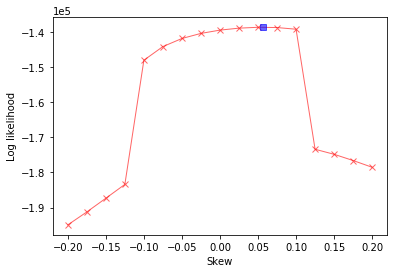

In [120]:
# v = np.load('logpdfs.npz')
# plt.plot(v['skews'], v['logpdfs'], 'r-x', v['inf_skew'], v['inf_logpdf'], 'bs', lw=1, alpha=0.6)
plt.plot(skews, logpdfs, 'r-x', inf_skew, inf_logpdf, 'bs', lw=1, alpha=0.6)
plt.ylabel('Log likelihood')
plt.xlabel('Skew')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()
# plt.savefig('/Users/sakaya/lambert-paper/skew.pdf')

In [26]:
# # def slambertw_logpdf_(y, loc, scale, skew, tol = 0.8):
# #     u = (y - loc)/scale
# #     if skew != 0:
# #         cutoff = - tol * 1/(np.e * skew)
# #         cond = u >= cutoff if skew < 0 else u <= cutoff
# #         wc = lambertw(skew*u)
# #         gc = 1./(np.exp(wc) + skew*u)
# #         z = wc/skew
        
# #         wc[cond] = wtmp = lambertw(skew * cutoff)
# #         gc[cond] = 1./(np.exp(wtmp) + skew*cutoff)
# #         z[cond] = wc[cond]/skew + (u[cond] - cutoff) * gc[cond]
        
# #         return norm.logpdf(z) + np.log(gc) - np.log(scale)
# #     else:
# #         return norm.logpdf(u) - np.log(scale)
# #def slambertw_(x, skew):
# #     cutoff = - 0.9 * 1/(np.e * skew)
# #     cond = x >= cutoff if skew < 0 else x <= cutoff
# #     wc = lambertw(skew * cutoff)
# #     gc = 1. / (np.exp(wc) + skew*cutoff)
# #     z = lambertw(skew*x)/skew
# #     z[cond] = wc/skew + (x[cond] - cutoff) * gc
# #     return z

# # def lambertw_logpdf_(y, loc, scale, skew):
# #     u = (y - loc)/scale
# #     if skew != 0:
# #         wc = lambertw(skew*u)
# #         gc = 1./(np.exp(wc) + skew*u)
# #         z = wc/skew
# # #         return norm.logpdf(z) + np.log(gc) - np.log(scale)
# #         return gc
# #     else:
# #         return norm.logpdf(u) - np.log(scale)
# lmap = precompute_lambertw(-2, 2, 100)
# # for k, v in lmap.items():
# #     print(k,v)
# lmap
# # lambertw = primitive(lambda x: lambertw_(x, 0).real)
# # defvjp(lambertw, 
# #         lambda ans, x: lambda g: g * 1./ (x + np.exp(ans)),
# #         None 
# #       )

# # def precompute_lambertw(a, b, resolution):
# #     x = np.linspace(a, b, resolution * (b - a) + 1)
# #     x[x < -1/np.e] = -1/np.e
# #     x_new = ((x - a) * resolution).astype(int)
# #     lmap = dict(zip(x_new, lambertw(x).real))
# #     def inner(x):
# #           x[x < -1/np.e] = -1/np.e
# # #         sel = ((x - a) * resolution).astype(np.int32)
# # #         return vals[sel]
# #     return lmap

# # tabl_w0 = create_lambert_table(-2, 2, 100)
# # xs = np.array([-0.1, 0.1, 0.4])
# # plt.plot(xs, tabl_w0(xs))
# # plt.plot(xs, lambertw(xs).real)
# # plt.show()

In [75]:
lambertw = primitive(lambda x: lambertw_(x, 0).real)
defvjp(lambertw, 
        lambda ans, x: lambda g: g * 1./ (x + np.exp(ans)),
        None 
      )

In [108]:
def lambertw(x):
    x = np.where(x < -1/np.e, -1/np.e, x)
    return lambertw_(x,0).real
lambertw = primitive(lambertw)
defvjp(lambertw, 
        lambda ans, x: lambda g: g * 1./ (x + np.exp(ans)),
        None 
      )

In [109]:
g = grad(lambertw)
x = np.linspace(-3,3,20)
lambertw(-1)
# g(1.)

-1.0000000044715198

In [98]:
lambertw(x)

array([[-0.36787944, -0.36787944],
       [-0.36787944, -0.36787944]])

In [142]:
lambertw = primitive(lambda x: lambertw_(x, 0).real)
defvjp(lambertw, 
        lambda ans, x: lambda g: g * 1./ (x + np.exp(ans)),
        None 
      )
def slambertw_logpdf_(y, loc, scale, skew, tol = 0.8):
    u = (y - loc)/scale
    if skew != 0:
        cutoff = - tol /(np.e * skew)
        cond = u >= cutoff if skew < 0 else u <= cutoff
        utmp = np.where(cond, cutoff, u)
        wc = lambertw(skew * utmp)
        gc = 1./(np.exp(wc) + skew*utmp)
        z = np.where(cond, wc/skew + (u - cutoff) * gc, wc/skew)
        return norm.logpdf(z) + np.log(gc) - np.log(scale)
    else:
        return norm.logpdf(u) - np.log(scale)

In [151]:
u = x
skew = 0.2
cutoff = - 0.9 /(np.e * skew)
cond = u >= cutoff if skew < 0 else u <= cutoff
utmp = np.where(cond, cutoff, u)
wc = lambertw(utmp * skew)
gc = 1./(np.exp(wc) + skew*utmp)
gc

array([ 4.69128123,  4.69128123,  4.69128123,  4.69128123,  4.69128123,
        4.69128123,  4.69128123,  4.69128123,  3.78007789,  1.27716755,
        0.82942925,  0.62670937,  0.50833241,  0.42982949,  0.37358055,
        0.33111166,  0.29780977,  0.27093561,  0.2487541 ,  0.23010984])

In [152]:
g = grad(lambertw)

In [153]:
np.array([g(u * skew) for u in utmp])

array([ 4.69128123,  4.69128123,  4.69128123,  4.69128123,  4.69128123,
        4.69128123,  4.69128123,  4.69128123,  3.78007789,  1.27716755,
        0.82942925,  0.62670937,  0.50833241,  0.42982949,  0.37358055,
        0.33111166,  0.29780977,  0.27093561,  0.2487541 ,  0.23010984])